## Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from wordcloud import WordCloud
import nltk # nltk:Natural Language Toolkit, 자연어 처리에 자주쓰이는 library
# 토큰화(단어 분리), 형태소 분석, 품사 태깅, 감정 분석 등
from nltk.corpus import stopwords # corpus: 말뭉치 (대규모 텍스트 데이터 집합), stopwords: 불용어 (영어, 독일어, 프랑스어, 스페인어 등 주요 유럽 언어 중심으로 제공). 한국어는 konlpy 사용
import spacy # ntlk는 연구용 범용 library(데이터많음/속도느림), spacy는 실무용 library(속도빠름)
from collections import Counter

import string

warnings.filterwarnings(action="ignore")

DATA_PATH = "/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/"

## EDA

### Data overview
> *추가 Feature 설명*  
> *원래 라벨링: 여러 명의 annotator(사람)가 각 댓글에 대해 해당 속성이 있는지 여부를 0 또는 1로 표시함.*  
> *최종 값: 각 속성에 대해 모든 annotator의 평균값을 사용 → 결과적으로 0~1 사이의 연속값이 됨.*  

* train  
  id: 그냥 넘버링  
  target: 댓글 공격성 (if toxicity >= 0.5 else 0 적용전)  
  comment_text: 대상 댓글
    
  *추가 Feature-세부공격성*  
  severe_toxitiy: 극단적 공격성 정도 [0,1]  
  obscene: 성적 비하 정도 [0,1]  
  identity_attack: 정체성(성별,종교,인종 등) 공격 정도 [0,1]  
  insult: 일반적 모욕성 정도 [0,1]  
  threat: 위해,위협 정도 [0,1]  
  sexual_explicit: 성적인 묘사 정도 [0,1]
    
  *추가 Feature-identity*  
  asian: 아시아인 언급여부  
  atheist: 무신론자 언급여부  
  bisexual: 양성애자 언급여부  
  black: 흑인 언급여부  
  buddhist: 불교신자 언급여부  
  christian: 기독교인 언급여부  
  female: 여성 언급여부  
  heterosexual: 이성애자 언급여부  
  hindu: 힌두교신자 언급여부  
  homosexual_gay_or_lesbian: 게이,레즈 언급여부  
  intellectual_or_learning_disability: 지적,학습장애 언급여부  
  jewish: 유대인 언급여부  
  latino: 중남미출신 언급여부  
  male: 남성 언급여부  
  muslim: 이슬람교인 언급여부  
  other disability: 지적,신체적 장애 외 기타장애 언급여부  
  other_gender: 남성,여성,트렌스젠더 외 다른 성별 언급여부  
  other_race_or_ethnicity: 흑인,백인,라틴,아시아인,아메리카원주민 외 다른 인종 언급여부  
  other_religion: 기독교,불교,유대교,이슬람교,힌두교 외 다른 종교 언급여부  
  other_sexual_orientation: 이성애자,동성애자,양성애자,게이,레즈 외 다른 성적정체성 언급여부  
  physical_disability: 신체적 장애 언급여부  
  psychiatric_or_mental_illness: 정신적 질병 언급여부  
  transgender: 트렌스젠더 언급여부  
  white: 백인 언급여부
    
  *추가 Feature-meta data*  
  created_date: 댓글 작성날짜  
  publication_id: 댓글달린 기사의 출판물 ID  
  parent_id: 댓글이 답글인 경우 부모 댓글 ID  
  article_id: 댓글이 달린 기사의 ID  
  rating: 댓글 공개 혹은 차단 여부 ['rejected', 'approved']    
  funny: 재밌어요 반응수  
  wow: 놀라워요 반응수  
  sad: 슬퍼요 반응수  
  likes: 좋아요 반응수  
  disagree: 동의하지 않아요 반응수  
  identity_annotator_count: identity 관련 feature 라벨링 참여인 수  
  toxicity_annotator_count: toxicity 관련 feature 라벨링 참여인 수

* test  
  id: 그냥 넘버링    
  comment_text: 대상 댓글

In [2]:
df_train = pd.read_csv(DATA_PATH+"train.csv")
df_test = pd.read_csv(DATA_PATH+"test.csv")
df_sample = pd.read_csv(DATA_PATH+"sample_submission.csv")

In [3]:
'''
all_data.csv
│
├── train.csv                     # 학습 데이터 (1.8M행)
└── test.csv                      # 채점용 데이터 (0.6M행)
     ├── test_public_expanded.csv   # test의 20% (Public LB용)
     └── test_private_expanded.csv  # test의 80% (Private LB용)

df_all = pd.read_csv(DATA_PATH+"all_data.csv")
df_identity = pd.read_csv(DATA_PATH+"identity_individual_annotations.csv")
df_toxicity = pd.read_csv(DATA_PATH+"toxicity_individual_annotations.csv")
df_test_private_expanded = pd.read_csv(DATA_PATH+"test_private_expanded.csv")
df_test_public_expanded = pd.read_csv(DATA_PATH+"test_public_expanded.csv")
'''

'\nall_data.csv\n│\n├── train.csv                     # 학습 데이터 (1.8M행)\n└── test.csv                      # 채점용 데이터 (0.6M행)\n     ├── test_public_expanded.csv   # test의 20% (Public LB용)\n     └── test_private_expanded.csv  # test의 80% (Private LB용)\n\ndf_all = pd.read_csv(DATA_PATH+"all_data.csv")\ndf_identity = pd.read_csv(DATA_PATH+"identity_individual_annotations.csv")\ndf_toxicity = pd.read_csv(DATA_PATH+"toxicity_individual_annotations.csv")\ndf_test_private_expanded = pd.read_csv(DATA_PATH+"test_private_expanded.csv")\ndf_test_public_expanded = pd.read_csv(DATA_PATH+"test_public_expanded.csv")\n'

In [4]:
df_train['rating'].unique()

array(['rejected', 'approved'], dtype=object)

In [5]:
df_train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
pd.set_option("display.max_colwidth", None) # 텍스트 데이터 생략 없이 전체 표기.
'''
여러 컬럼은 전달 시 dataframe 2차원이라서 두겹으로 작성.
단일 컬럼은 series라서 한겹.
'''
df_train.sample(30)[['id', 'target', 'comment_text']]

,id,target,comment_text
1439674,5879132,0.000000,"Most small business owners use their corporations to earn and save income for retirement, then once retired split that hard earned money with their spouses. The current proposals would eliminate the ability to split this form of retirement income with a spouse. On the other hand, all of the MPs have glorious pensions which get $6.25 of tax funded matching for every $1 they contribute. So in 2016, when an MP contributed his max of $25,370, his tax funded matching was $158,532.50, for a total accumulated value of $183,932.50. So after serving 6 years the MP has a retirement nest egg of $1,103,595 which he is allowed to split with his spouse upon retirement and is fully indexed. The spouse never worked to earn that income, yet is allowed to split it. If Morneau and the Liberals want to talk about fairness, maybe they should start with a look in the mirror! Most pensions offer a maximum of 1-1 matching. Although I doubt any politician, red, blue, yellow or green would vote to pass this!"
638068,1022568,0.000000,"Then I set the wrong tone. I do believe that checks and balances are working concerning the first Trump decree. I am not so well versed in immigration law that I know the eventual outcome. I believe the Bannon administration likes to create chaos and they thrive on it. I don't mind that part of it. I'm more concerned that some in the public realm believe them without question about a legal interpretation that hasn't been fully reveiwed. When the spokeman says the Presidents orders must be followed, I get a bit nervous.\n\nI hope our legal institutions are solid enough to stand their ground against any administration, including this one. I am no populist, I have no desire to be under mob rule. I presume you feel the same way UC."
750975,5040086,0.000000,"This writer Buda is smart person,as compare to the ""anti"" gang that come on and cry about progress, about developers and growth. If we put our apples in these anti people care, they would rot. Such negative energy."
1022809,5367903,0.000000,"Do the math. 100 employees at $150,000 per year cost is $15 million and, yes, that's what it will cost counting fringes. Then rent office space in Anchorage, Fairbanks, Juneau and Wasilla. Now, infrastructure - computers, IT specialists, paper, office machinery. Vehicles, travel, utilities, web design, FaceBook page. PR, advertising. Heck, $50 million is probably low."
408979,743325,0.000000,"The famous Russian steamroller. Wars always have uncertain outcomes. Russian forces performed badly in Chechnya, relying on firepower to grind a lightly armed adversary into dust. In the war with Georgia, Russian ground forces were painfully slow and would have been an easy target to a NATO nation. They haven't done all that well in Syria either having just been booted out of the T4 airbase in Palmyra by ISIS . The Russian army still uses mostly equipment that dates from the early 90s. The air wing from Admiral Kuznetsov had to be transferred to a ground base in Syria since the ship is falling apart. Furthermore, Russian dependence on oil exports makes it an easy target for embargo and sanctions.The point is, such action would leave no choice for NATO but to fully implement article 5. It's simply a matter of time before NATO's military, which is mostly out of reach to Russia, would compel your government into contemplating a nuclear option. Think Putin would retain power for long?"
914138,5238248,0.166667,"Of course Toronto needs to have aligned regulatory forms for small business - and providing simple on-line portals. \n\nBut engaging the Province will slow the thing down, muck it up, and see untold tax dollars wasted. Queen's Park has a known history of ineptitude on providing on-line portals for the public - particularly in its economic development departments that serve businesses. \n\nIt's too bad that City Hall can't go it alone by working with Ryerson and local small business associations 

In [7]:
df_train.shape

(1804874, 45)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [9]:
df_train['comment_text'].apply(type).value_counts()

comment_text
<class 'str'>      1804871
<class 'float'>          3
Name: count, dtype: int64

In [10]:
def missing_count(df: pd.DataFrame) -> pd.Series:
    """
    각 컬럼별 결측치 개수를 반환하는 함수
    df.count() 기반으로 계산
    """
    n_rows = len(df)
    return n_rows - df.count()
    # df.count()는 non-null만 세기에 isnull.sum()보다 빠름

missing = missing_count(df_train)
print(missing)

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [11]:
# 문자형 unique 확인
df_train.describe(include="object").T

,count,unique,top,freq
comment_text,1804871,1780822,Well said.,184
created_date,1804874,1804362,2015-10-13 18:40:35.757707+00,4
rating,1804874,2,approved,1684758


In [12]:
# 수치형 
df_train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
id,1804874.0,3738433.79,2445186.76,59848.0,796975.25,5223774.5,5769854.50,6334010.00
target,1804874.0,0.10,0.20,0.0,0.00,0.0,0.17,1.00
severe_toxicity,1804874.0,0.00,0.02,0.0,0.00,0.0,0.00,1.00
obscene,1804874.0,0.01,0.06,0.0,0.00,0.0,0.00,1.00
identity_attack,1804874.0,0.02,0.08,0.0,0.00,0.0,0.00,1.00
insult,1804874.0,0.08,0.18,0.0,0.00,0.0,0.09,1.00
threat,1804874.0,0.01,0.05,0.0,0.00,0.0,0.00,1.00
asian,405130.0,0.01,0.09,0.0,0.00,0.0,0.00,1.00
atheist,405130.0,0.00,0.05,0.0,0.00,0.0,0.00,1.00
bisexual,405130.0,0.00,0.03,0.0,0.00,0.0,0.00,1.00


In [13]:
df_test.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\nDoes this apply to President Trump too?
1,7097321,This is malfeasance by the Administrator and the Board. They are wasting our money!
2,7097322,"@Rmiller101 - Spoken like a true elitist. But look out bud. The re-awakening in Europe, Brexit and now the Trump victory are just the beginning. The unwashed masses are coming for you and your ilk…."
3,7097323,"Paul: Thank you for your kind words. I do, indeed, have strong beliefs and don't hide them. They are based on both facts and values. I think the question of ""bias"" and ""prejudice"" comes into play when we're discussing beliefs and attitudes based on values. One of our poster friends, for example, often comments that being ""intolerant"" of a bias, for example, is, in itself, a bias. This is, IMO, where the concept of ""irratonal antipathy"" is important. If I dislike neo-Nazis because of their views on race, my antipathy is based on fact (knowledge of their views) and values (my belief that condemning others because of their race/religion is WRONG). Were I to, instead, dislike all Germans, that, IMO, would represent a bias...an irrational antipathy...since not all Germans condemn others because of their race/religion. I discuss the ""bias"" question in another response to you....\n\nIt's an interesting topic and I'd enjoy discussing it w/you sometime. Give me a call. Gary Crum"
4,7097324,Sorry you missed high school. Eisenhower sent troops to Vietnam after the French withdrew in 1954 and before that America was providing 50% of the cost of that war. WWI & WWII were won by Democrat Presidents and the last win a Republican had was 1865 but the did surrender in Korea and Vietnam and fail to win in desert Storm or these two wars.


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            97320 non-null  int64 
 1   comment_text  97320 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [15]:
df_test.shape

(97320, 2)

### Visualization

### count check
* 데이터 불균형 심함
* 0이 아니라 1 맞추는 것에 집중
* toxicity가 있는 문장들의 경우 주기성이 보임. 점수 마킹 후 정규화의 패턴으로 추측

In [16]:
df_train['target_bin'] = df_train['target'].map(
    lambda x : 1 if x>=0.5 else 0
) # 임의로 설정해서 toxicity와 아닌 문장의 비율을 확인

df_train[['target','target_bin','comment_text']].sample(3)

,target,target_bin,comment_text
391816,0.0,0,"This is a clear indication that Richmond BC is a fraud hub with help by the city to be - I imagine they have a lot of bribes disguised as ""investment"" to deliberately ignore the very obvious crimes occurring.\n\nRCMP should investigate the City and there should be a tremendous amount of confiscating lands and deporting people. A stop to the student fast-track program should be done immediately and panda bonds no longer issued."
68438,0.7,1,"Always evil fox news, Bush, etc isn't it, silence the naysayers and off with their head!; there goes your credibility. The useful idiots on your side are really shills for the America-Bad Left whose real agenda is to lower us to the common social denominator and entirely predictable. And really, the constant GW hand wringing by this author (2 weeks straight) and this paper is very boring and reflects a political bent rather than reporting news that matters. At the end of the day there isn't anything practical this or the next generation of Americans can do to start ""cooling the earth"" assuming that's even the supposed goal. But if so, maybe Air Force One, the Gore-Tex wearing plastic Kayakers Inc. et al would lead by example but I doubt it."
617661,0.0,0,"Regarding: "" “...it is also clear for us as Catholics that loyalty to the pope is substantial for the Catholic faith.”""\n- No doubt 'catholic' hear means those catholics who are in communion and union with the successor to Peter, the archbishop of Rome. There are a great many catholics who are in neither communion, or union.\n- No doubt 'loyalty' means being attentive to the ArchborRome as the one with whom one is in union and communion.\n- The relationship of communion and union allows for a great deal of dialog, discussion, and disagreement. In such a relationship the 'taught church' (body of christ) effectively teaches the 'teaching church' (the successors of the apostles)."


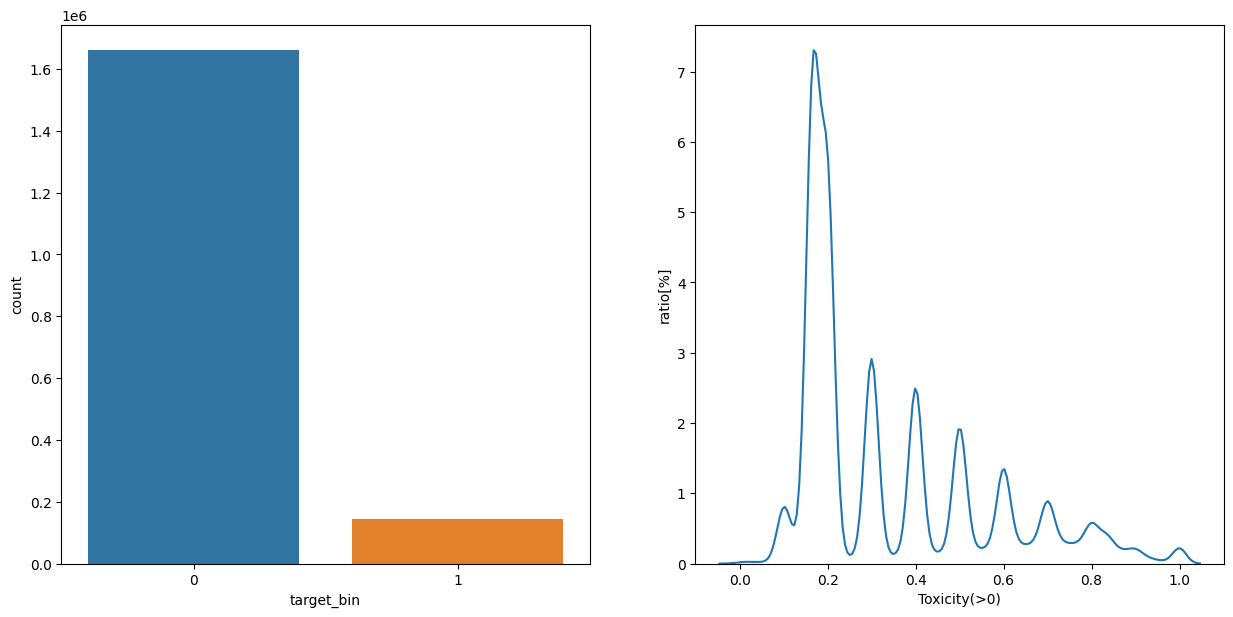

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
sns.countplot(x='target_bin', data=df_train, ax=ax1)
sns.kdeplot(x='target', data=df_train[df_train['target'] > 0], ax=ax2)
ax2.set_ylabel("ratio[%]")
ax2.set_xlabel("Toxicity(>0)")
plt.show()

### 텍스트 시각화: 워드클라우드
* 전체적으로 그리고 insult에도 특이하게 trump가 크게 보임. 당시 시기가 미국 대선이었나?  
  *2016년 11월 미국 대통령 선거: 트럼프 vs 클린턴*  
  *데이터는 2017년 수집*  
* like, want, tell, say 같이 대화체 verb도 주로 보이고
* 제대로 분석하려면 verb를 제껴야 할거 같은데: 모든 verb를 삭제하는 건 'attack'같은 유의미 verb까지 삭제  
  *따라서 frequency 기반으로 일반 verb 추출해서 stop_words에 포함*

In [18]:
stop_words = stopwords.words("english")
# 필요에 따라 stop_words.append(), stop_words.remove() 가능

In [19]:
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

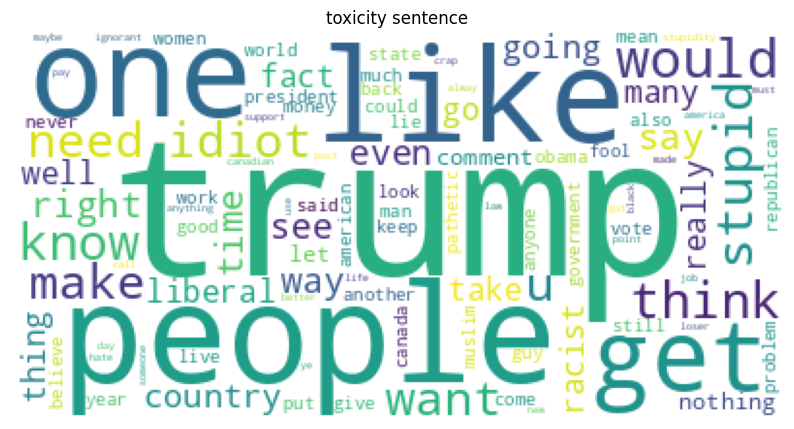

In [20]:
# df.loc[행조건, 열선택]
# 반환값은 Series(index, dtype까지 존재) -> tolist()로 list로 변환
# df_train.loc[df_train['target']>0, 'comment_text'].tolist()
toxicity_lists = df_train[df_train['target']>0.5]['comment_text'].tolist()
toxicities = " ".join(toxicity_lists).lower() # 문자열 method = "구분자".join(리스트)
# Dataframe.join과는 다름. df1.join(df2, how="left", on="key")

wc_toxic = WordCloud(
    max_font_size=100, 
    max_words=100, 
    background_color='white', 
    stopwords=stop_words
).generate(toxicities)

plt.figure(figsize=(10,10))
plt.imshow(wc_toxic)
plt.axis("off")
plt.title("toxicity sentence")
plt.show()


In [21]:
stop_words = stop_words.append('would')

In [22]:
def wordcloud(feature, df, target_text='comment_text', stopwords=stop_words, threshold=0.5, grid_ax=None):
    lists = df[df[feature]>threshold][target_text].tolist()
    texts = " ".join(lists).lower()

    wc = WordCloud(
        width=400, height=300, # WordCloud()는 기본적으로 (400, 200)의 가로로 긴 직사각형 크기
        max_font_size=100, 
        max_words=80, 
        background_color='white', 
        stopwords=stopwords
    ).generate(texts)

    # grid_ax가 주어졌다면 해당 축에 그림
    if grid_ax is not None:
        ax = grid_ax
    else:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    ax.imshow(wc)
    ax.axis("off")
    ax.set_title(f"{feature} sentence")

    if grid_ax is None:
        plt.show()

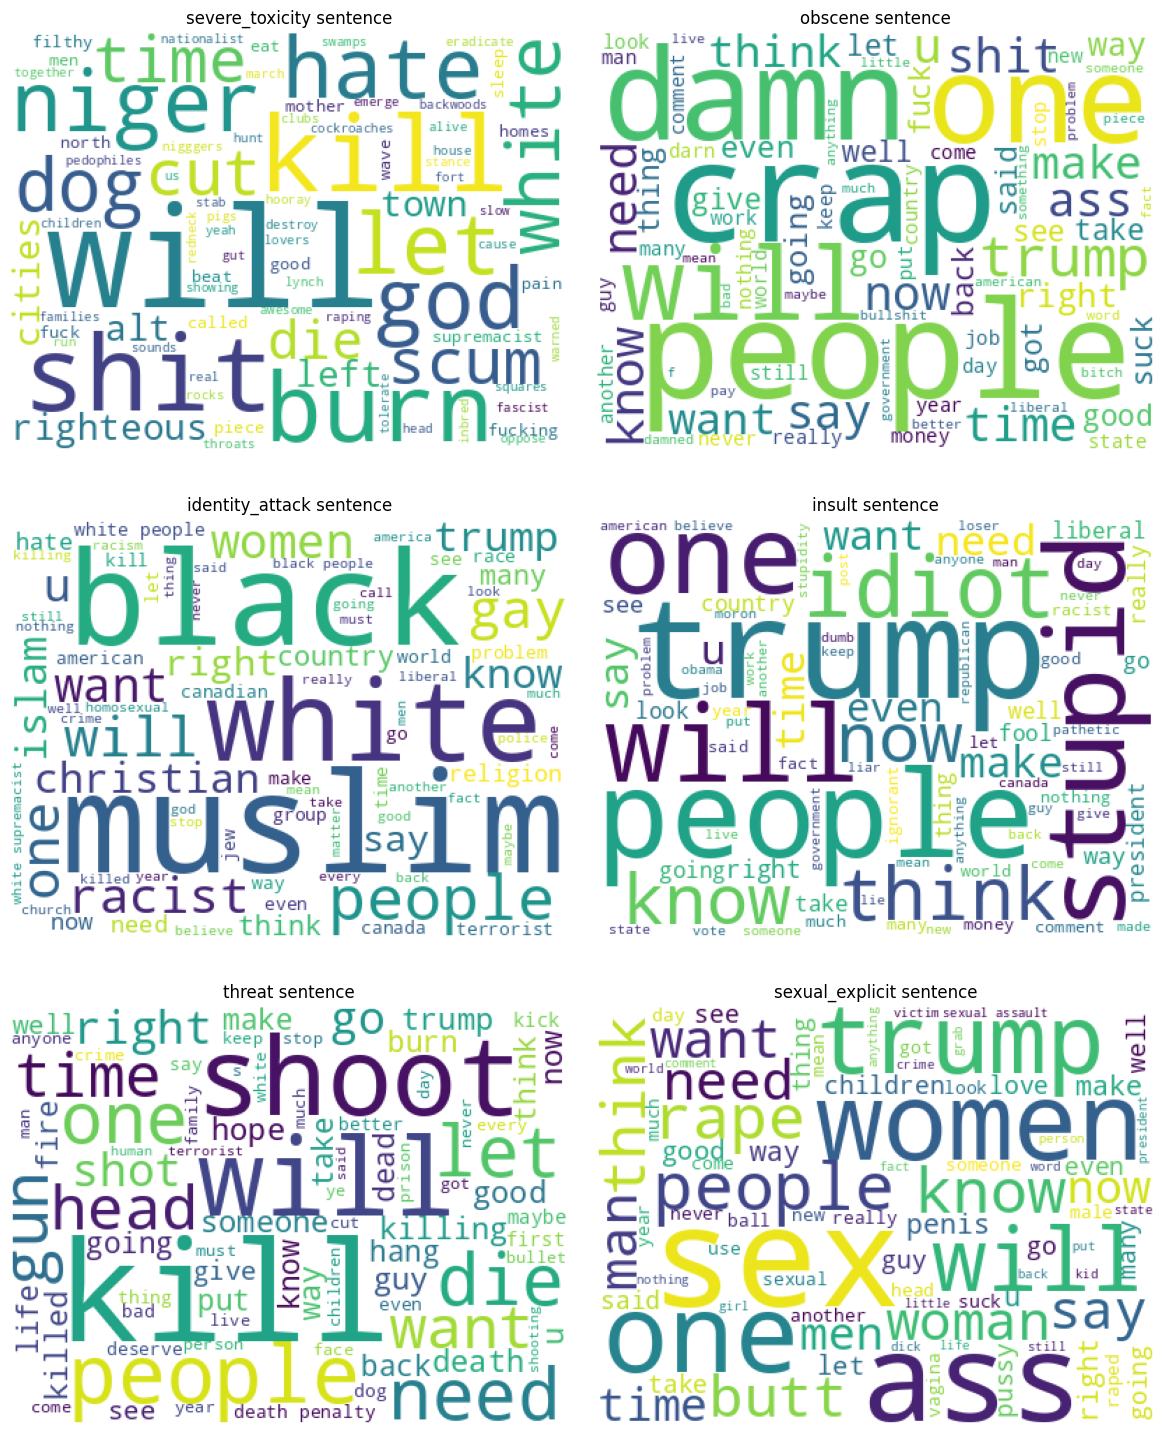

In [23]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
for i, feature in enumerate(features):
    ax = axes.flat[i]
    wordcloud(feature, df_train, grid_ax=ax)

plt.tight_layout(pad=2.0)
plt.show()

In [24]:
# !python -m spacy download en_core_web_md

In [ ]:
# 중형(md) langauge model(영어) 로드 (LLM은 Large language model)
# 언어모델: 주어진 텍스트에서 다음 단어를 예측하거나 문장의 구조와 의미를 파악하는 모델
lm = spacy.load("en_core_web_md")

texts = df_train['comment_text'].apply(str).tolist()  # 샘플링도 하나의 방법

# 모든 동사 lemma(원형) 추출
verbs = []
for doc in lm.pipe(texts, batch_size=5000, disable=["ner", "parser"]): # slm로 texts를 batch(한꺼번에)처리. 이때 parser, ner는 끄고 진행
    # 처리결과는 Doc 객체: 한 문장(혹은 텍스트 전체)을 분석한 결과를 담는 컨테이너
    verbs.extend([token.lemma_.lower() for token in doc if token.pos_ == "VERB"])
    # append 대신 extend 사용 -> 다중 리스트를 풀어서 삽입. 통재로 리스트 째로 삽입 X

# 빈도 계산
verb_counts = Counter(verbs)
verb_df = pd.DataFrame(verb_counts.most_common(100), columns=["verb", "count"])

In [ ]:
print(verb_df.head(50))

In [ ]:
stop_words.extend(verb_df['verb'][:20].tolist())

In [ ]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
for i, feature in enumerate(features):
    ax = axes.flat[i]
    wordcloud(feature, df_train, grid_ax=ax)

plt.tight_layout(pad=2.0)
plt.show()

### Text Statistics

In [ ]:
# Number of words in each sentences
df_train["num_words"] = df_train['comment_text'].apply(
    lambda sen:len(str(sen).split())
)
# str(): 처리해야 혹시모를 숫자나 이상한 문자 안전처리 가능
# split(" "): 이건 정확하게 space 1칸짜리만 분할
# split(): 이건 (2칸이든 1칸이든 탭이든 개행이든) 모든 공백기준으로 분할
df_test["num_words"] = df_test['comment_text'].apply(
    lambda sen:len(str(sen).split())
)

# Number of stop_words in each sentences
df_train["num_stopwords"] = df_train['comment_text'].apply(
    lambda sen:len([word for word in str(sen).lower().split() if word in stop_words])
)
df_test["num_stopwords"] = df_test['comment_text'].apply(
    lambda sen:len([word for word in str(sen).lower().split() if word in stop_words])
)

df_train["avg_word_len"] = df_train['comment_text'].apply(
    # lambda sen:sum(len(word) for word in str(sen).split())/len(str(sen).split())
    lambda sen:np.mean([len(word) for word in str(sen).split()])
)
df_test["avg_word_len"] = df_test['comment_text'].apply(
    lambda sen:np.mean([len(word) for word in str(sen).split()])
)

In [ ]:
sns.displot(df_train['num_words'], bins=100)
plt.show()

In [ ]:
sns.displot(df_train['num_stopwords'], bins=100)
plt.show()

In [ ]:
sns.displot(df_train['avg_word_len'], bins=100)
plt.show()